In [1]:
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

import laspated as spated

# Limit borders

In [2]:
# initial map used as max borders
max_borders = gpd.read_file(r'../Data/rj/')
print(type(max_borders))
max_borders

<class 'geopandas.geodataframe.GeoDataFrame'>


,OBJECTID_1,OBJECTID,MUN,SHAPE_LENG,SHAPESTAre,SHAPESTLen,geometry
0,2,NaN,NaN,NaN,1.204148e+09,375647.256369,"MULTIPOLYGON (((682113.651 7469305.612, 682113..."


<Axes: >

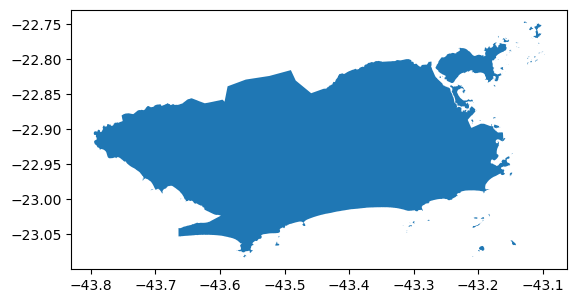

In [3]:
app = spated.DataAggregator(crs='epsg:4326') # epsg:29193
app.add_max_borders(max_borders)

app.max_borders.plot()

# Events data

In [4]:
# events data
events = pd.read_csv(r'../data/emergency_calls_rio_de_janeiro.csv')
events.head(10)

,date,priority,latitude,longitude
0,01/01/2016 02:09,3,-22.869398,-43.333665
1,01/01/2016 02:13,0,-22.876186,-43.675890
2,01/01/2016 02:17,1,-22.906627,-43.293335
3,01/01/2016 02:28,0,-23.012424,-43.541721
4,01/01/2016 02:44,2,-23.010306,-43.359431
5,01/01/2016 02:45,3,-22.930439,-43.233050
6,01/01/2016 02:51,0,-22.851838,-43.357152
7,01/01/2016 02:56,3,-23.002122,-43.634019
8,01/01/2016 02:57,2,-22.994583,-43.253164
9,01/01/2016 03:00,0,-22.824990,-43.392745


In [5]:
app.add_events_data(events.sample(1000), datetime_col='date', lat_col='latitude', lon_col='longitude', feature_cols=['priority'])

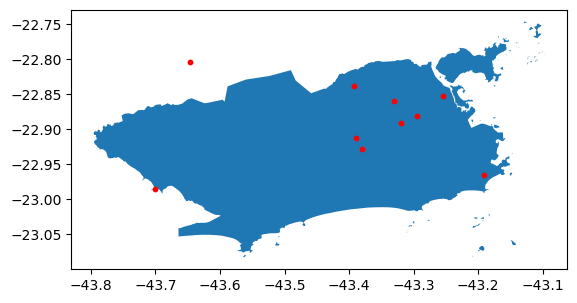

In [6]:
fig, ax = plt.subplots()
app.max_borders.plot(ax=ax)
app.events_data.sample(10).plot(markersize=10, color='red', ax=ax)
plt.show()

## We can also compute max borders based on events data!

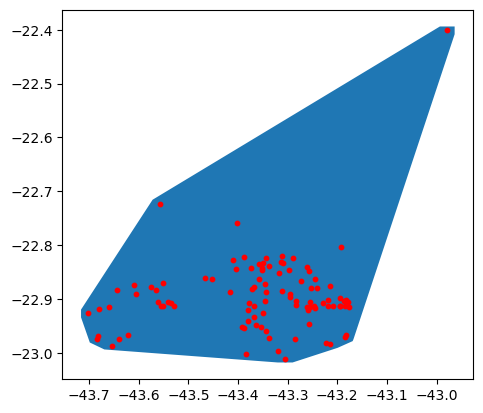

In [7]:
app2 = spated.DataAggregator(crs='epsg:4326')
# first, add events
app2.add_events_data(events.sample(100), datetime_col='date', lat_col='latitude', lon_col='longitude', feature_cols=['priority'])
# then, compute borders with desired method
app2.add_max_borders(method="convex")

fig, ax = plt.subplots()
app2.max_borders.plot(ax=ax)
app2.events_data.plot(markersize=10, color='red', ax=ax)
plt.show()

# Time discretization

## Basic Seasonality

In [8]:
# 7 days in a week
app.add_time_discretization('D', 1, 7)

# 48 30-minute slots in a day
app.add_time_discretization('m', 30, 60*24)

## Variable Window Time Discretization

In [9]:
app.add_time_discretization('M', [3,4,2,1,2], 12)

## Custom Time Discretization

In [10]:
time_disc_df = pd.DataFrame([
    ["2016-01-01", "2016-01-01", 1, "yearly"],
    ["2016-02-06", "2016-02-11", 2, None],
    ["2017-02-24", "2017-03-06", 2, None],
], columns=["start", "end", "t", "repetition"])

time_disc_df

,start,end,t,repetition
0,2016-01-01,2016-01-01,1,yearly
1,2016-02-06,2016-02-11,2,None
2,2017-02-24,2017-03-06,2,None


In [11]:
app.add_time_discretization(time_disc_df)

All time discretizations are represented as columns in the events dataset.

In [12]:
app.events_data.head(10)

,priority,geometry,ts,tdiscr_1,tdiscr_2,tdiscr_3,tdiscr_4
100,1,POINT (-43.35637 -22.87016),2016-01-01 08:45:00,0,17,0,1
414,3,POINT (-43.46363 -22.71066),2016-01-01 20:03:00,0,40,0,1
467,3,POINT (-43.18214 -22.80164),2016-01-01 22:36:00,0,45,0,1
630,3,POINT (-43.25166 -22.87221),2016-01-02 11:35:00,1,23,0,0
965,0,POINT (-43.39812 -22.84339),2016-01-03 09:07:00,2,18,0,0
1222,2,POINT (-43.48160 -22.87524),2016-01-03 22:31:00,2,45,0,0
1424,1,POINT (-43.59007 -22.91136),2016-01-04 13:46:00,3,27,0,0
1798,0,POINT (-43.30992 -22.85086),2016-01-05 12:28:00,4,24,0,0
1895,1,POINT (-43.17544 -22.90610),2016-01-05 15:14:00,4,30,0,0
2136,3,POINT (-43.19438 -22.89564),2016-01-06 10:40:00,5,21,0,0


# Geographical discretization

## Rectangular

In [13]:
app.add_geo_discretization(
    discr_type='R',
    rect_discr_param_x=10,
    rect_discr_param_y=10
)
app.geo_discretization.head()

D:\Programs\Anaconda\envs\new-geo\lib\site-packages\IPython\core\interactiveshell.py:3460: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,neighbors,geometry,center_lat,center_lon
0,0,"[1, 6, 7]","POLYGON ((-43.65578 -23.04919, -43.65578 -23.0...",-4.854788e+06,-2.563144e+06
1,1,"[2, 0, 7, 8, 6]","POLYGON ((-43.65578 -23.04919, -43.58592 -23.0...",-4.850097e+06,-2.563096e+06
2,2,"[3, 1, 8, 9, 7]","MULTIPOLYGON (((-43.58592 -23.04919, -43.52824...",-4.843598e+06,-2.564044e+06
3,3,"[2, 9, 10, 8]","MULTIPOLYGON (((-43.50822 -23.05259, -43.50818...",-4.838225e+06,-2.564489e+06
4,4,"[5, 13, 12]","MULTIPOLYGON (((-43.19084 -23.07197, -43.19110...",-4.803047e+06,-2.565301e+06


In [14]:
app.geo_discretization["center"] = app.geo_discretization.geometry.to_crs("epsg:29193").centroid.to_crs(app.geo_discretization.crs)
app.geo_discretization["coords"] = app.geo_discretization["center"].apply(lambda x: x.representative_point().coords[:][0])

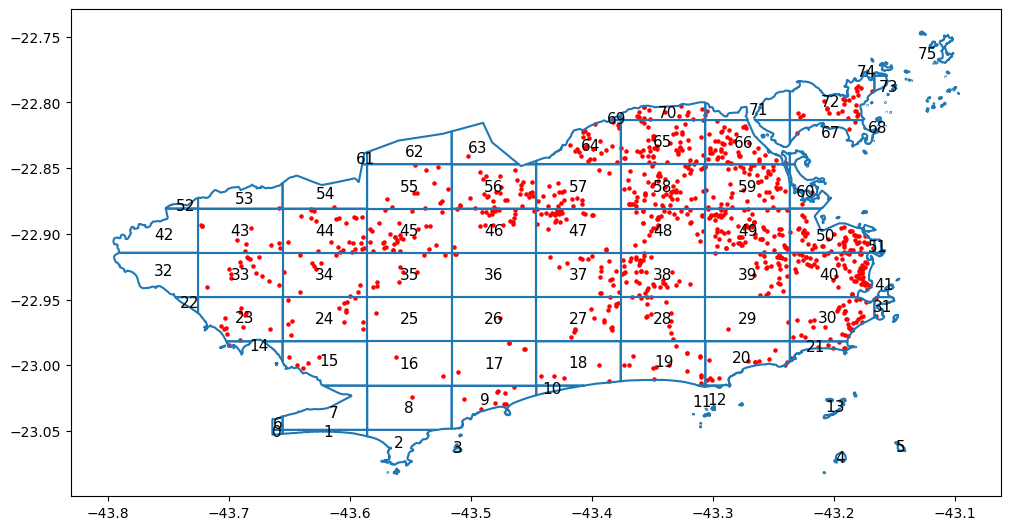

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
app.geo_discretization.boundary.plot(ax=ax)
app.events_data.sample(1000).dropna(subset=['gdiscr']).plot(markersize=5, color='red', ax=ax)
for _, row in app.geo_discretization.iterrows():
    plt.annotate(
        text=row["id"],
        xy=row['coords'],
        horizontalalignment="center",
        verticalalignment="center",
        color='black', fontsize=11
    )

## Hexagonal

In [16]:
app.add_geo_discretization(
    discr_type='H',
    hex_discr_param=7
)
app.geo_discretization.head()

D:\Programs\Anaconda\envs\new-geo\lib\site-packages\IPython\core\interactiveshell.py:3460: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,neighbors,geometry,center_lat,center_lon
0,0,"[143, 51, 134, 184, 215, 190]","POLYGON ((-43.26776 -22.91103, -43.27467 -22.9...",-4.810335e+06,-2.546406e+06
1,1,"[62, 64, 92, 70, 139, 189]","POLYGON ((-43.31285 -22.99674, -43.31976 -22.9...",-4.815349e+06,-2.555938e+06
2,2,"[68, 211, 204]","POLYGON ((-43.32992 -22.81170, -43.33734 -22.8...",-4.819665e+06,-2.536618e+06
3,3,"[12, 56, 16, 217, 103, 87]","POLYGON ((-43.57778 -22.97907, -43.59211 -22.9...",-4.846400e+06,-2.553932e+06
4,4,"[130, 194, 117, 100, 216, 48]","POLYGON ((-43.39729 -22.92950, -43.38296 -22.9...",-4.824796e+06,-2.550874e+06


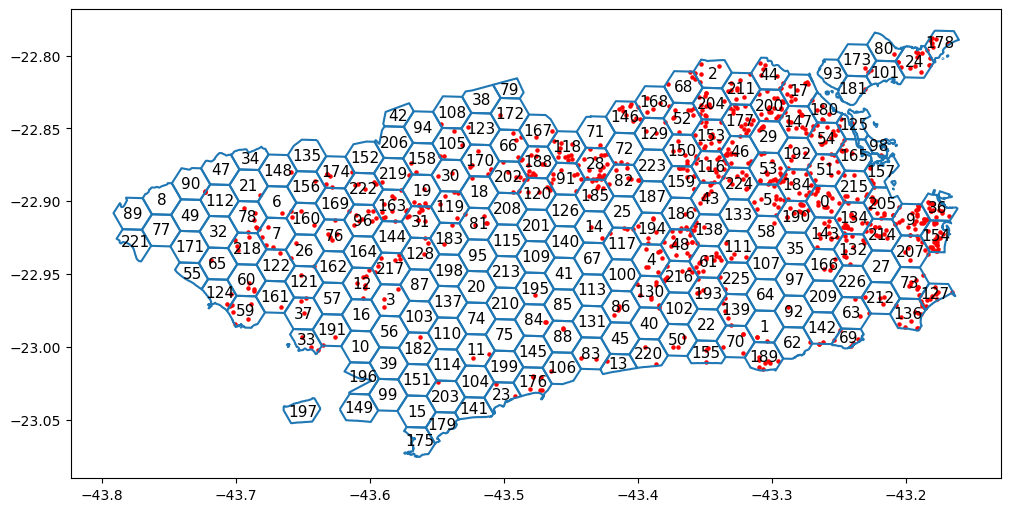

In [17]:
centers = app.geo_discretization.geometry.to_crs("epsg:29193").centroid.to_crs(app.geo_discretization.crs)
coords = centers.apply(lambda x: x.representative_point().coords[:][0])

fig, ax = plt.subplots(figsize=(12, 8))
app.geo_discretization.boundary.plot(ax=ax)
app.events_data.sample(1000).dropna(subset=['gdiscr']).plot(markersize=5, color='red', ax=ax)
for ind, row in app.geo_discretization.iterrows():
    plt.annotate(
        text=row["id"],
        xy=coords.loc[ind],
        horizontalalignment="center",
        verticalalignment="center",
        color='black', fontsize=11
    )


## Custom from graph (doesn't support regressors)

In [18]:
# read nodes data
f = open(r'../data/street_nodes.txt', "r")
nodes = pd.DataFrame([r.strip().split(" ") for r in f.readlines()], columns=["id", "lat", "lon"])

nodes["id"] = nodes["id"].astype(int)
nodes["lat"] = nodes["lat"].astype(float)
nodes["lon"] = nodes["lon"].astype(float)

# transform to geodataframe
nodes = gpd.GeoDataFrame(
    nodes, 
    geometry=gpd.points_from_xy(nodes.lon, nodes.lat)
).set_crs(app.crs).sample(100)

In [19]:
nodes

,id,lat,lon,geometry
25631,25631,-22.8719,-43.2521,POINT (-43.25210 -22.87190)
90230,90231,-22.9130,-43.5200,POINT (-43.52000 -22.91300)
187225,187226,-22.8903,-43.2942,POINT (-43.29420 -22.89030)
52505,52506,-22.8276,-43.3887,POINT (-43.38870 -22.82760)
52424,52425,-22.9318,-43.2428,POINT (-43.24280 -22.93180)
...,...,...,...,...
197298,197299,-22.9953,-43.5511,POINT (-43.55110 -22.99530)
174938,174939,-22.8977,-43.6058,POINT (-43.60580 -22.89770)
198650,198651,-22.9175,-43.1865,POINT (-43.18650 -22.91750)
261080,261082,-22.8775,-43.2411,POINT (-43.24110 -22.87750)


In [20]:
app.add_geo_discretization('G', custom_data=nodes)
app.geo_discretization.head(20)

,geometry,id
25631,POINT (-43.25210 -22.87190),0
90230,POINT (-43.52000 -22.91300),1
187225,POINT (-43.29420 -22.89030),2
52505,POINT (-43.38870 -22.82760),3
52424,POINT (-43.24280 -22.93180),4
107038,POINT (-43.46920 -23.02940),5
228939,POINT (-43.34610 -22.81550),6
168920,POINT (-43.68880 -22.95660),7
41399,POINT (-43.18570 -22.80800),8
143304,POINT (-43.33320 -22.97510),9


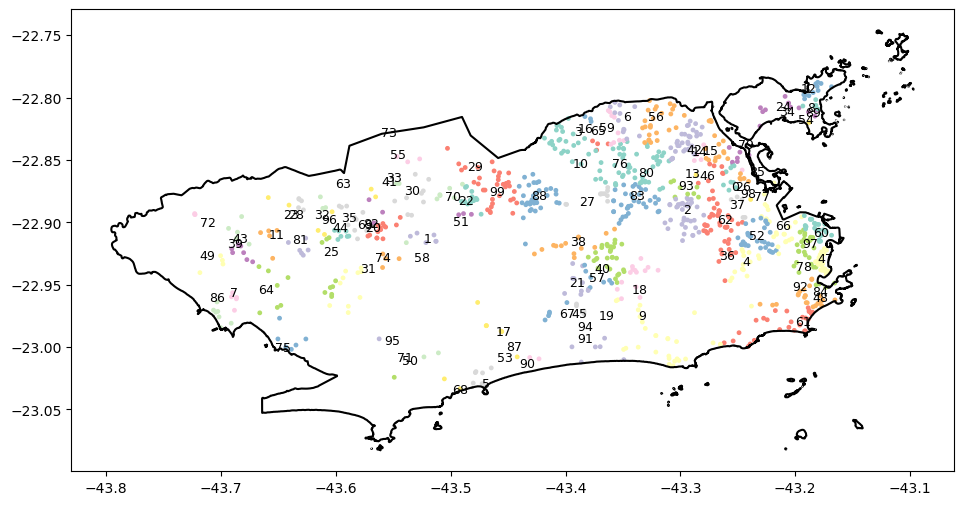

In [21]:
centers = app.geo_discretization.geometry.to_crs("epsg:29193").centroid.to_crs(app.geo_discretization.crs)
coords = centers.apply(lambda x: x.representative_point().coords[:][0])

fig, ax = plt.subplots(figsize=(12, 6))
app.max_borders.boundary.plot(ax=ax, color="black")
app.events_data.dropna(subset=['gdiscr']).plot(markersize=6, column='gdiscr', ax=ax, cmap="Set3")

for ind, row in app.geo_discretization.iterrows():
    plt.annotate(
        text=row["id"],
        xy=coords.loc[ind],
        horizontalalignment="center",
        verticalalignment="center",
        color='black', fontsize=9
    )
plt.show()

## Custom from map

In [22]:
# custom map
custom_map = gpd.read_file(r'../data/rio_de_janeiro_neighborhoods')
print(type(custom_map))
custom_map = custom_map.set_crs('epsg:29193')
custom_map.head()

<class 'geopandas.geodataframe.GeoDataFrame'>


,Área,NOME,REGIAO_ADM,AREA_PLANE,CODBAIRRO,CODRA,CODBNUM,LINK,area,len,geometry
0,1.705684e+06,Paquetá,PAQUETA,1,13,21,13,Paquetá&area=13,1.705684e+06,24841.426123,"MULTIPOLYGON (((694555.510 7483079.800, 694554..."
1,4.056403e+06,Freguesia,ILHA DO GOVERNADOR,3,98,20,98,Freguesia&area=98,4.056403e+06,18303.596291,"MULTIPOLYGON (((687736.110 7480093.850, 687735..."
2,9.780466e+05,Bancários,ILHA DO GOVERNADOR,3,97,20,97,Bancários&area=97,9.780466e+05,7758.781330,"MULTIPOLYGON (((685934.980 7479388.550, 685937..."
3,1.895742e+07,Galeão,ILHA DO GOVERNADOR,3,104,20,104,Galeão&area=104,1.895742e+07,21510.058418,"MULTIPOLYGON (((681940.940 7479375.300, 681947..."
4,1.672546e+06,Tauá,ILHA DO GOVERNADOR,3,101,20,101,Tauá&area=101,1.672546e+06,8246.109606,"POLYGON ((686812.130 7477581.700, 686796.080 7..."


In [23]:
app.add_geo_discretization('C', custom_data=custom_map)
app.geo_discretization.head()

D:\Programs\Anaconda\envs\new-geo\lib\site-packages\IPython\core\interactiveshell.py:3460: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


,geometry,id,neighbors,center_lat,center_lon
0,"MULTIPOLYGON (((-43.10572 -22.74885, -43.10573...",0,[],-4.793761e+06,-2.531267e+06
1,"MULTIPOLYGON (((-43.17175 -22.77659, -43.17175...",1,[2],-4.800155e+06,-2.533540e+06
2,"MULTIPOLYGON (((-43.18920 -22.78316, -43.18918...",2,"[1, 4, 9]",-4.801518e+06,-2.534405e+06
3,"MULTIPOLYGON (((-43.22809 -22.78371, -43.22803...",3,"[5, 14]",-4.807679e+06,-2.536113e+06
4,"POLYGON ((-43.18044 -22.79937, -43.18060 -22.7...",4,"[2, 6, 9, 11]",-4.802147e+06,-2.534989e+06


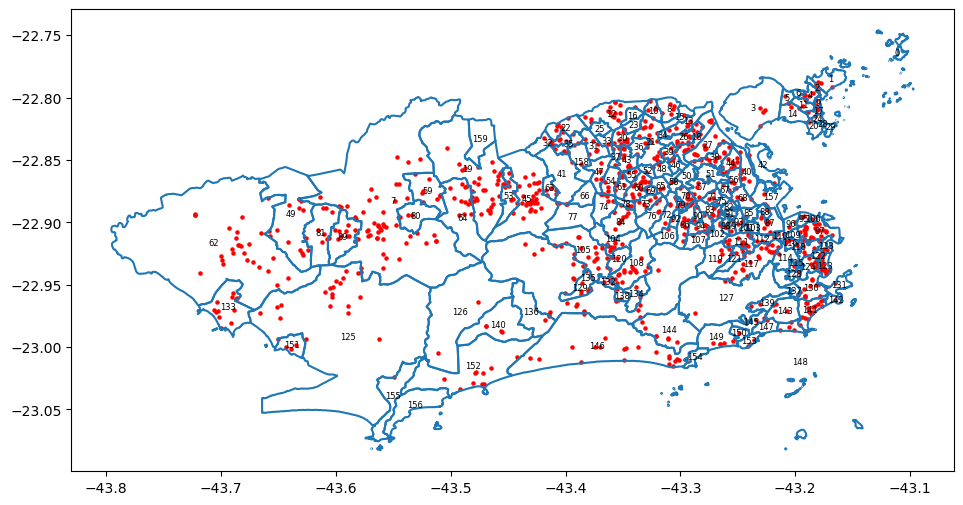

In [24]:
centers = app.geo_discretization.geometry.to_crs("epsg:29193").centroid.to_crs(app.geo_discretization.crs)
coords = centers.apply(lambda x: x.representative_point().coords[:][0])

fig, ax = plt.subplots(figsize=(12, 6))
app.geo_discretization.boundary.plot(ax=ax)
app.events_data.sample(1000).dropna(subset=['gdiscr']).plot(markersize=5, color='red', ax=ax)

for ind, row in app.geo_discretization.iterrows():
    plt.annotate(
        text=row["id"],
        xy=coords.loc[ind],
        horizontalalignment="center",
        verticalalignment="center",
        color='black', fontsize=6
    )

# Add geo located regressors

## Population

In [37]:
app.add_geo_discretization(
    discr_type='H',
    hex_discr_param=7
)

D:\Programs\Anaconda\envs\new-geo\lib\site-packages\IPython\core\interactiveshell.py:3460: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [38]:
population = gpd.read_file(r'../Data/regressores/populacao/')
print(population.columns)
population = population[['populacao_','populaca_1','populaca_2','populaca_3','geometry']].copy()
population.head()

Index(['Área', 'bairro', 'REGIAO_ADM', 'AREA_PLANE', 'CODBAIRRO', 'CODRA',
       'CODBNUM', 'LINK', 'area', 'len', '<1', '1', '2', '3', '4', '5 a 9',
       '10 a 14', '15', '16 a 17', '18 a 19', '20 a 24', '25 a 29', '30 a 34',
       '35 a 39', '40 a 44', '45 a 49', '50 a 54', '55 a 59', '60 a 64',
       '65 a 69', '70 a 74', '75 a 79', '>=80', 'populacao_', 'populaca_1',
       'populaca_2', 'populaca_3', 'geometry'],
      dtype='object')


,populacao_,populaca_1,populaca_2,populaca_3,geometry
0,639.0,620.0,1324.0,778.0,"MULTIPOLYGON (((-43.10530 -22.74839, -43.10531..."
1,13692.0,14914.0,31346.0,10559.0,"MULTIPOLYGON (((-43.17133 -22.77613, -43.17133..."
2,2598.0,2903.0,5298.0,1713.0,"MULTIPOLYGON (((-43.18878 -22.78270, -43.18876..."
3,6205.0,5608.0,9468.0,1690.0,"MULTIPOLYGON (((-43.22767 -22.78325, -43.22761..."
4,6700.0,6862.0,12185.0,3820.0,"POLYGON ((-43.18002 -22.79891, -43.18018 -22.7..."


<Axes: >

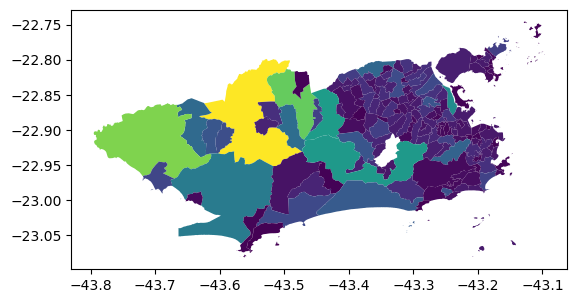

In [39]:
population.plot(column='populacao_')

In [40]:
app.add_geo_variable(population)

<Axes: >

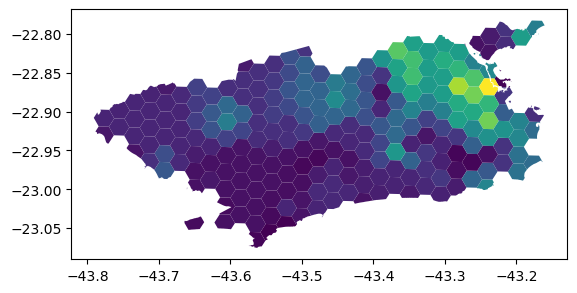

In [41]:
app.geo_discretization.plot(column='populacao_')

# Final Data Structure

In [42]:
app.events_features, app.geo_features, app.time_indexes, app.geo_index

(['priority'],
 ['populacao_',
  'populaca_1',
  'populaca_2',
  'populaca_3',
  'populacao_',
  'populaca_1',
  'populaca_2',
  'populaca_3'],
 ['tdiscr_1', 'tdiscr_2', 'tdiscr_3', 'tdiscr_4'],
 'gdiscr')

In [43]:
app.events_data

,priority,geometry,ts,tdiscr_1,tdiscr_2,tdiscr_3,tdiscr_4,gdiscr
index,,,,,,,,
100,1,POINT (-43.35637 -22.87016),2016-01-01 08:45:00,0,17,0,1,150.0
414,3,POINT (-43.46363 -22.71066),2016-01-01 20:03:00,0,40,0,1,NaN
467,3,POINT (-43.18214 -22.80164),2016-01-01 22:36:00,0,45,0,1,24.0
630,3,POINT (-43.25166 -22.87221),2016-01-02 11:35:00,1,23,0,0,51.0
965,0,POINT (-43.39812 -22.84339),2016-01-03 09:07:00,2,18,0,0,146.0
...,...,...,...,...,...,...,...,...
285615,0,POINT (-43.48617 -22.87127),2017-12-31 01:13:00,2,2,4,0,188.0
285711,1,POINT (-43.47226 -23.02079),2017-12-31 10:15:00,2,20,4,0,176.0
285787,1,POINT (-43.24892 -22.98857),2017-12-31 14:27:00,2,28,4,0,142.0
